In [2]:
library(ISLR)
library(MASS)
library(data.table) 
library(ggplot2)
library(dplyr)
library(e1071)
library(rpart)
library(caret)
library(tidyverse)
library(ggplot2)
library(stringr)
library(ISLR)

Warning message:
"package 'ISLR' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'e1071' was built under R version 3.4.3"Loading required package: lattice
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
between():   dplyr, data.table
filter():    dplyr, stats
first():     dplyr, data.table
lag():       dplyr, stats
last():      dplyr, data.table
lift():      purrr, caret
select():    dplyr, MASS
transpose(): purrr, data.table


In [24]:
colorstats <- read.csv('Stats.csv')
colorstats %>%
  select(Percentage.Black, Percentage.White, Percentage.Blue, Percentage.Red, Percentage.Yellow,
         Percentage.Green, Percentage.Purple, People, Percentage.Cyan, Number.of.Likes) ->stat
stat %>%
    filter(Number.of.Likes <=150) -> stat1

stat1 %>%
    select(Percentage.Black, Percentage.White, Percentage.Blue, Percentage.Red, Percentage.Yellow,
         Percentage.Green, Percentage.Purple, Percentage.Cyan) ->sorted
cbind(sorted, t(apply(sorted, 1, sort, decreasing = TRUE))) -> sorted1
colnames(sorted1) <- c("Percentage.Black", "Percentage.White", "Percentage.Blue", "Percentage.Red", "Percentage.Yellow",
                     "Percentage.Green","Percentage.Purple","Percentage.Cyan", "Color1", "Color2", "Color3",
                     "Color4", "Color5", "Color6", "Color7", "Color8")
sorted1 %>%
 select(Color1, Color2, Color3, Color4, Color5, Color6, Color7, Color8) ->domcolor
dompcolor <- domcolor
domcolor$Likes <- stat1$Number.of.Likes
dompcolor$People <- stat1$People

In [25]:
domcolor$Likes=log(domcolor$Like)
train = 1:200
Colors.train = domcolor[train, ]
Colors.test = domcolor[-train, ]

Warning message:
"package 'gbm' was built under R version 3.4.3"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


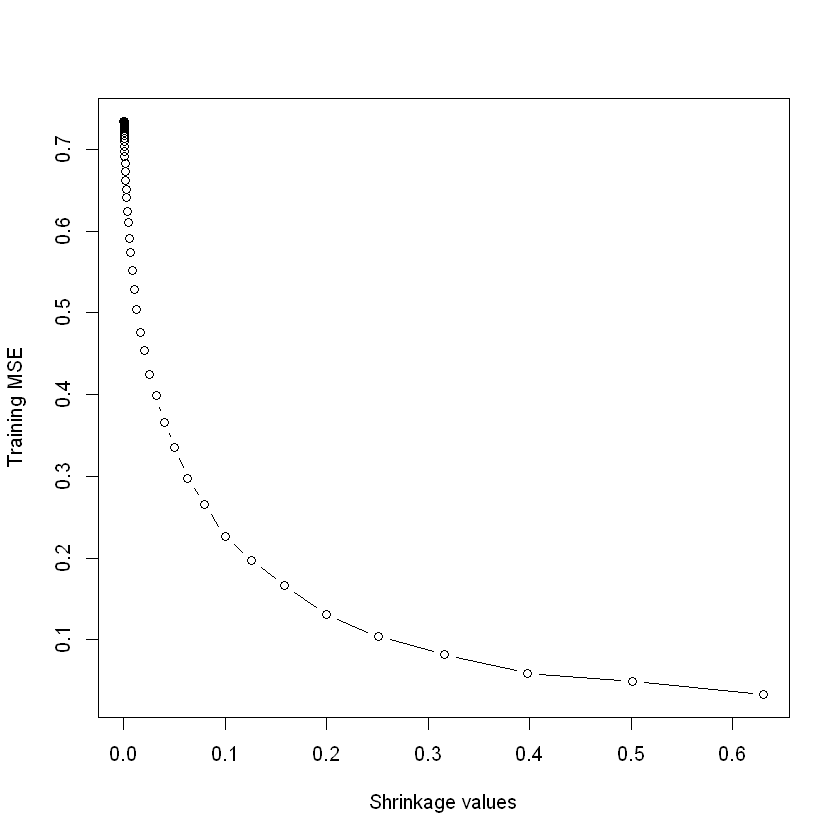

In [26]:
library(gbm)
set.seed(20)
pows <- seq(-10, -0.2, by = 0.1)
lambdas <- 10^pows
trainerror <- rep(0, length(lambdas))
for (i in 1:length(lambdas)) {
    boost.color <- gbm(Likes~., data=Colors.train, distribution = "gaussian",n.trees=1000,shrinkage=lambdas[i])
    pred.train <- predict(boost.color,Colors.train, n.trees = 1000)
    trainerror[i] <- mean((pred.train - Colors.train$Likes)^2)
}

plot(lambdas, trainerror, type = "b", xlab = "Shrinkage values", ylab = "Training MSE")


[1] 0.8740557

[1] 0.0006309573

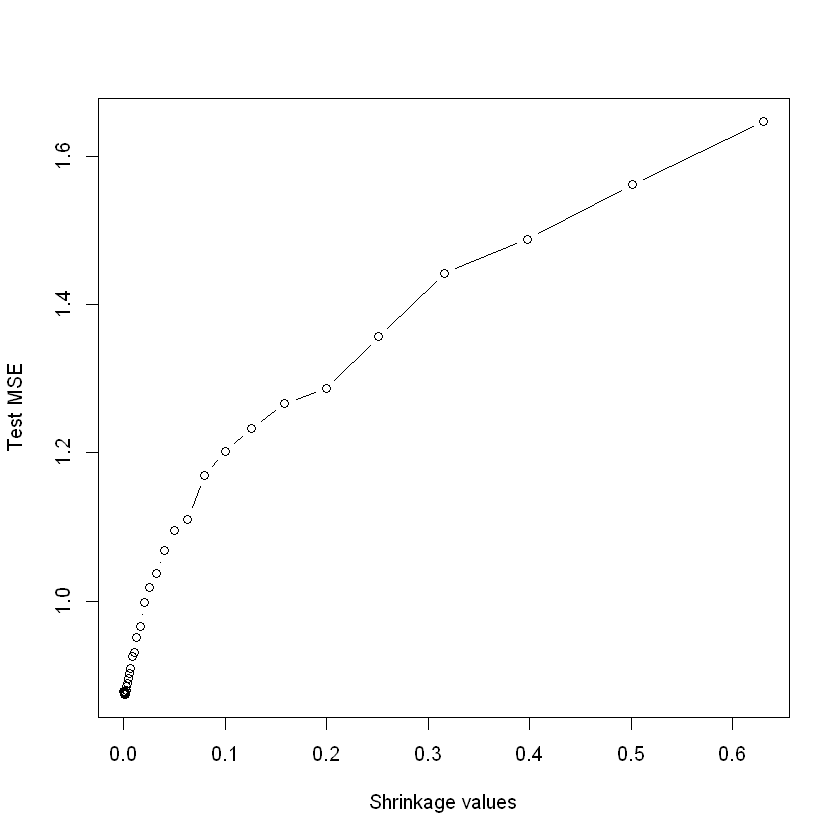

In [27]:
testerr = rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
    hit = gbm(Likes ~., data=Colors.train, distribution = "gaussian", n.trees = 1000, shrinkage = lambdas[i])
    pred1 = predict(hit, Colors.test, n.trees = 1000)
    testerr[i] = mean((pred1 - Colors.test$Likes)^2)
}
plot(lambdas, testerr, type = "b", xlab = "Shrinkage values", ylab = "Test MSE")


min(testerr)
lambdas[which.min(testerr)]

In [28]:
library(glmnet)
fit1 = lm(Likes ~ ., data = Colors.train)
pred1 = predict(fit1, Colors.test)
mean((pred1 - Colors.test$Likes)^2)

x = model.matrix(Likes ~ ., data = Colors.train)
x.test = model.matrix(Likes ~ ., data = Colors.test)
y = Colors.train$Likes
fit2 = glmnet(x, y, alpha = 0)
pred2 = predict(fit2, s = 0.01, newx = x.test)
mean((pred2 - Colors.test$Likes)^2)

lassofit = glmnet(x, y, alpha = 1) 
lassopred = predict(lassofit, s = 0.01, newx = x.test) 
mean((lassopred - Colors.test$Likes)^2)

Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loaded glmnet 2.0-13



[1] 0.8981727

[1] 0.895772

[1] 0.8904531

,var,rel.inf
Color4,Color4,71.564148
Color6,Color6,6.979925
Color3,Color3,6.598513
Color7,Color7,4.031260
Color2,Color2,3.578162
Color5,Color5,2.958945
Color1,Color1,2.766891
Color8,Color8,1.522155


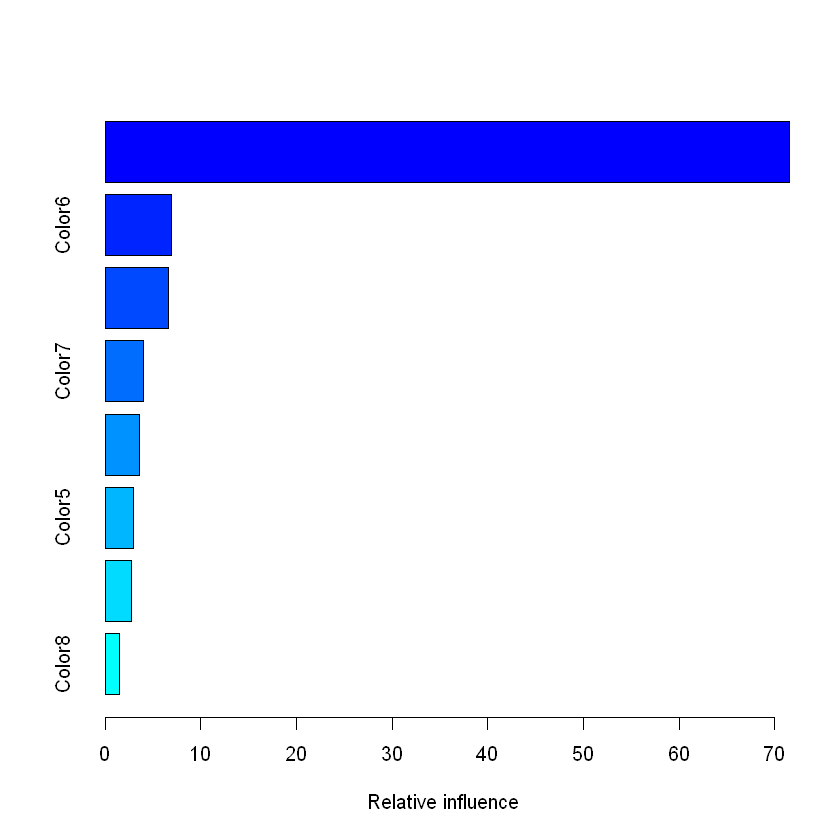

In [29]:
boost = gbm(Likes~.,data=Colors.train,distribution="gaussian", n.trees = 1000,shrinkage = lambdas[which.min(testerr)])
#or is it testerror instead?
summary(boost)


In [31]:
library(randomForest)
set.seed(120)

#2
bag=randomForest(Likes~.,Colors.train,mtry=19,importance=TRUE) 
bagpredict=predict(bag,Colors.test)
bagmse=mean((bagpredict-Colors.test$Likes)^2)
bagmse

Warning message in randomForest.default(m, y, ...):
"invalid mtry: reset to within valid range"

[1] 1.027218

In [32]:
cor(domcolor)
#cor(domcolor[,-9])

,Color1,Color2,Color3,Color4,Color5,Color6,Color7,Color8,Likes
Color1,1.00000000,-0.85024914,-0.78567907,-0.70614853,-0.40415042,-0.30771256,-0.24445540,-0.168085956,0.033030023
Color2,-0.85024914,1.00000000,0.41746987,0.32729571,0.15562477,0.13188074,0.10324749,0.095543170,-0.021021962
Color3,-0.78567907,0.41746987,1.00000000,0.71954593,0.26533991,0.13710618,0.11113338,0.070049575,-0.036168252
Color4,-0.70614853,0.32729571,0.71954593,1.00000000,0.35561440,0.21565381,0.14363054,0.078673008,-0.066293133
Color5,-0.40415042,0.15562477,0.26533991,0.35561440,1.00000000,0.72339535,0.55648608,0.277690634,0.029809651
Color6,-0.30771256,0.13188074,0.13710618,0.21565381,0.72339535,1.00000000,0.66863088,0.399017036,0.044020519
Color7,-0.24445540,0.10324749,0.11113338,0.14363054,0.55648608,0.66863088,1.00000000,0.594419752,0.056980990
Color8,-0.16808596,0.09554317,0.07004957,0.07867301,0.27769063,0.39901704,0.59441975,1.000000000,0.009841528
Likes,0.03303002,-0.02102196,-0.03616825,-0.06629313,0.02980965,0.04402052,0.05698099,0.009841528,1.000000000


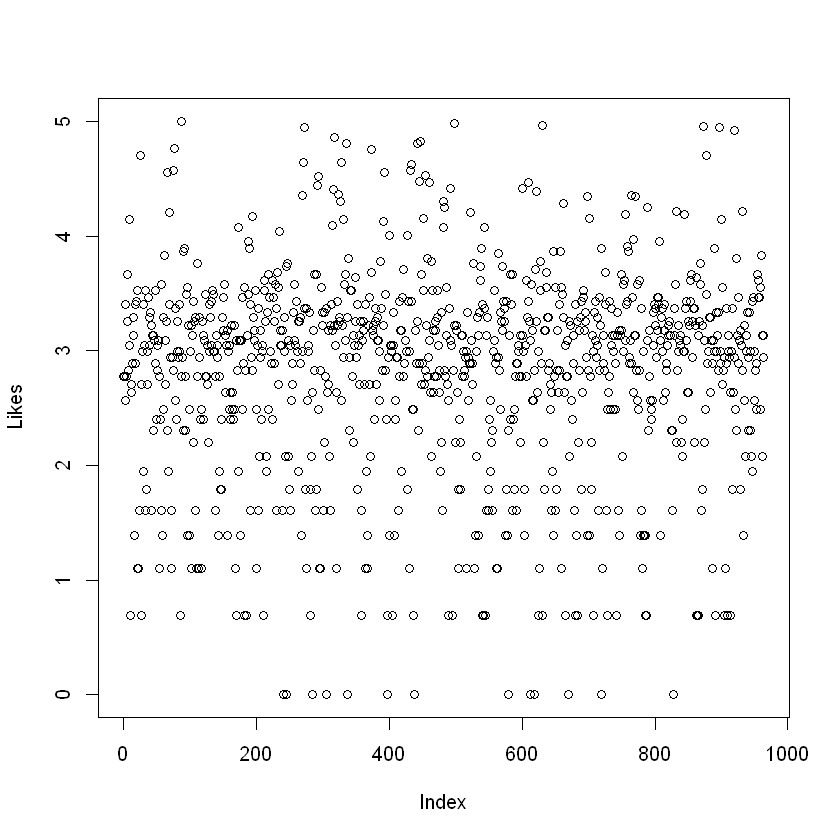

In [34]:
attach(domcolor)
plot(Likes)

In [41]:
glm.fit=glm(Likes~.,data=domcolor, family=binomial)
summary(glm.fit)

ERROR: Error in eval(family$initialize): y values must be 0 <= y <= 1


In [ ]:
coef(glm.fit)

In [ ]:
summary(glm.fit)$coef

In [ ]:
glm.probs=predict(glm.fit,type="response")
glm.probs[1:10]

In [ ]:
glm.pred=rep("Down",1250)
glm.pred[glm.probs>0.5]="Up"

In [ ]:
table(glm.pred,Direction)
mean(glm.pred==Direction)

In [ ]:
train=(Year<2005)
Smarket.2005=Smarket[!train,]
Direction.2005=Direction[!train]
glm.fit=glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume,
           data=Smarket, family=binomial,subset=train)
glm.probs=predict(glm.fit,Smarket.2005,type="response")

In [ ]:
glm.pred=rep("Down",252)
glm.pred[glm.probs>.5]="Up"
table(glm.pred,Direction.2005)

In [ ]:
mean(glm.pred==Direction.2005)
mean(glm.pred!=Direction.2005)

In [ ]:
predict(glm.fit,newdata=data.frame(Lag1=c(1.2,1.5),Lag2=c(1.1,-0.8)),type="response")

In [43]:
#lda here
library(MASS)
lda.fit=lda(Likes~Color1*Color2, data=domcolor, subset=train)
lda.fit

Call:
lda(Likes ~ Color1 * Color2, data = domcolor, subset = train)

Prior probabilities of groups:
0.693147180559945  1.09861228866811  1.38629436111989   1.6094379124341 
            0.035             0.045             0.035             0.045 
 1.79175946922805  1.94591014905531  2.19722457733622  2.30258509299405 
            0.015             0.020             0.010             0.020 
 2.39789527279837    2.484906649788  2.56494935746154  2.63905732961526 
            0.040             0.040             0.010             0.020 
 2.70805020110221  2.77258872223978  2.83321334405622  2.89037175789616 
            0.025             0.055             0.030             0.020 
 2.94443897916644  2.99573227355399  3.04452243772342  3.09104245335832 
            0.035             0.045             0.045             0.045 
 3.13549421592915  3.17805383034795   3.2188758248682  3.25809653802148 
            0.040             0.015             0.025             0.025 
 3.29583686600433   3.33

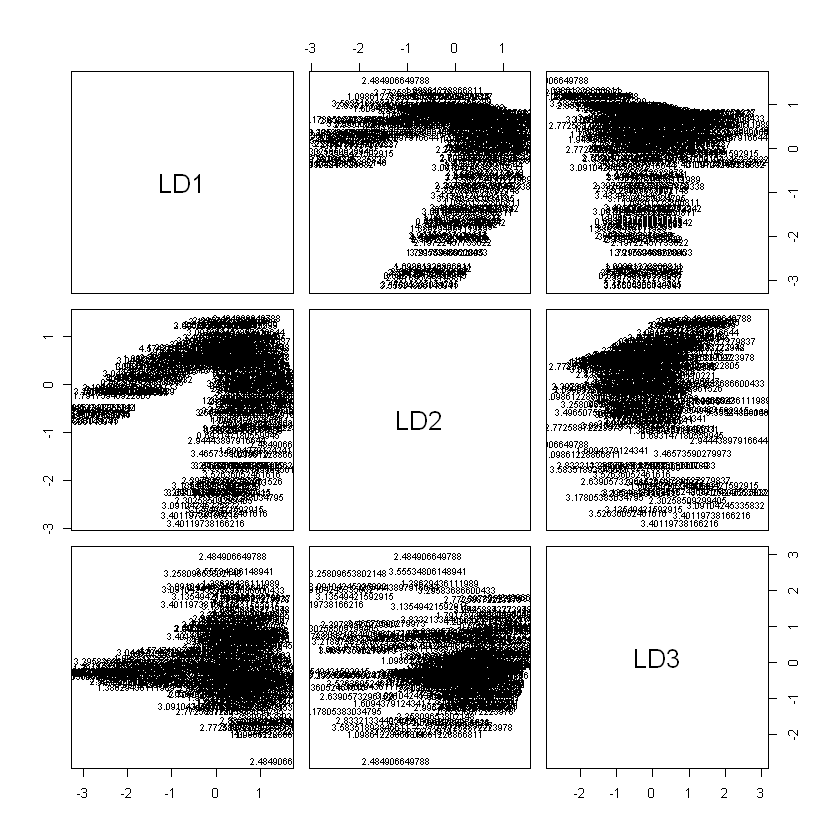

In [44]:
plot(lda.fit)

In [ ]:
lda.pred=predict(lda.fit, Smarket.2005)
names(lda.pred)
lda.class=lda.pred$class
table(lda.class,Direction.2005)
mean(lda.class==Direction.2005)

In [47]:
lda.fit=lda(Likes~Color1*Color2*Color3*Color4, data=domcolor, subset=train)
lda.fit

Call:
lda(Likes ~ Color1 * Color2 * Color3 * Color4, data = domcolor, 
    subset = train)

Prior probabilities of groups:
0.693147180559945  1.09861228866811  1.38629436111989   1.6094379124341 
            0.035             0.045             0.035             0.045 
 1.79175946922805  1.94591014905531  2.19722457733622  2.30258509299405 
            0.015             0.020             0.010             0.020 
 2.39789527279837    2.484906649788  2.56494935746154  2.63905732961526 
            0.040             0.040             0.010             0.020 
 2.70805020110221  2.77258872223978  2.83321334405622  2.89037175789616 
            0.025             0.055             0.030             0.020 
 2.94443897916644  2.99573227355399  3.04452243772342  3.09104245335832 
            0.035             0.045             0.045             0.045 
 3.13549421592915  3.17805383034795   3.2188758248682  3.25809653802148 
            0.040             0.015             0.025             0.025 
 

In [ ]:
plot(lda.fit)

In [ ]:
qda.fit=qda(Direction~Lag1+Lag2, data=Smarket, subset=train)
qda.fit

In [ ]:
qda.class=predict(qda.fit,Smarket.2005)$class
table(qda.class,Direction.2005)
mean(qda.class==Direction.2005)

In [ ]:
library(class)
train.X=cbind(Lag1,Lag2)[train,]
test.X=cbind(Lag1,Lag2)[!train,]
train.Direction=Direction[train]

In [ ]:
set.seed(1)
knn.pred=knn(train.X,test.X,train.Direction,k=1)
table(knn.pred,Direction.2005)
#change k accordingly
lda.fit = lda(Direction ~ Lag2:Lag1, data = Weekly, subset = train)
lda.pred = predict(lda.fit, Weekly.200910)
table(lda.pred$class, Direction.200910)
mean(lda.pred$class == Direction.200910)

qda.fit = qda(Direction ~ Lag2 + sqrt(abs(Lag2)), data = Weekly, subset = train)
qda.class = predict(qda.fit, Weekly.200910)$class
table(qda.class, Direction.200910)

mean(qda.class == Direction.200910)

In [ ]:
library(glmnet)
fit1 <- lm(Salary ~ ., data = Hitters.train)
pred1 <- predict(fit1, Hitters.test)
mean((pred1 - Hitters.test$Salary)^2)

x <- model.matrix(Salary ~ ., data = Hitters.train)
x.test <- model.matrix(Salary ~ ., data = Hitters.test)
y <- Hitters.train$Salary
fit2 <- glmnet(x, y, alpha = 0)
pred2 <- predict(fit2, s = 0.01, newx = x.test)
mean((pred2 - Hitters.test$Salary)^2)

#3

lasso.fit = glmnet(x, y, alpha = 1) #NOT HAS
lasso.pred = predict(lasso.fit, s = 0.01, newx = x.test) #NOT HAS

In [ ]:
boost.hitters = gbm(Salary~.,data=Hitters.train,distribution="gaussian", n.trees = 1000,shrinkage = lambdas[which.min(test.err)])
summary(boost.hitters)

In [ ]:
set.seed(120)
bag.hitters <- randomForest(Salary ~ ., data = Hitters.train, mtry = 19, ntree = 500)
yhat.bag <- predict(bag.hitters, newdata = Hitters.test)
mean((yhat.bag - Hitters.test$Salary)^2)

#2
hitters.bagging<-randomForest(Salary~.,hitters.train,mtry=19,importance=TRUE) #NO HAS
hitters.bagg.predict<-predict(hitters.bagging,hitters.test)
hitters.bagg.test.mse<-mean((hitters.bagg.predict-hitters.test$Salary)^2)
hitters.bagg.test.mse
